# Previsão de Engajamento - Classificação

Este notebook define modelos e hiperparâmetros e executa um validação cruzada aninhada com grid search para otimização de hiperparâmetros e treinamento.

- Entrada: `full-preproc2-inputs_(NOME_DO_MODELO)_(REDE_SOCIAL)` 
e `full-preproc2-outputs_(NOME_DO_MODELO)_(REDE_SOCIAL)`
- Saída: `resultados/resultados50p_{START_DATE_STR}_{SUB_DATASET}_(NOME_DO_MODELO)_(REDE_SOCIAL).npy`


In [159]:
#@title Importações de pacote
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [160]:
BASE_PATH = 'dados/preprocessed/'
MODEL_NAME = 'mxbai-embed-large-v1'
SOCIAL_NETWORK = 'tiktok'

# 1 - Carregando os Dados

Carregando dados brutos gerais.

In [161]:
dfx = pd.read_excel(f"{BASE_PATH}full-preproc2-inputs_{MODEL_NAME}_{SOCIAL_NETWORK}.xlsx", index_col='ID')
dfx.drop(columns=["Only Hashtags"],inplace=True)
dfx.head()

,Candidato_Bolsonaro,Candidato_Lula,Dias Decorridos,x1,x2,x3,x4,x5,x6,x7,...,x1015,x1016,x1017,x1018,x1019,x1020,x1021,x1022,x1023,x1024
ID,,,,,,,,,,,,,,,,,,,,,
7115033431473474822,0,1,94,-0.136752,-0.004471,-0.197404,0.771875,0.271732,-0.831048,0.572798,...,0.991231,-0.179094,0.009374,-0.510456,0.732227,-0.253170,0.185578,0.151233,-0.443790,-0.479070
7115174031162215686,0,1,94,-0.202921,0.046833,-0.182256,0.666116,0.354371,-0.201803,0.526789,...,1.219669,-0.223046,-0.214730,-0.466289,0.785575,-0.121878,0.218252,0.497084,-0.662330,0.082123
7115357413712153861,0,1,93,0.029744,0.393452,-0.301938,0.995043,-0.297031,-0.431491,1.016083,...,0.703671,0.198557,-0.226507,-0.561226,0.717053,0.401612,-0.630034,-0.050426,-0.719983,-0.286128
7115560675824422149,0,1,93,-0.185425,0.782692,-0.086695,0.831251,0.337393,-0.693311,0.471492,...,0.841613,-0.037051,-0.316676,-0.510069,0.825399,0.095525,-0.296313,0.055677,-0.575535,-0.053547
7115793869152734470,0,1,92,0.068613,-0.065852,-0.359612,0.638832,-0.074697,-0.239683,0.304781,...,0.919486,0.173887,-0.563785,-0.028777,0.640279,0.146346,-0.096667,0.012495,-0.735688,-0.274756


In [162]:
dfy_full = pd.read_excel(f"{BASE_PATH}full-preproc2-outputs_{MODEL_NAME}_{SOCIAL_NETWORK}.xlsx", index_col='ID')
dfy_full.head()

,Curtidas,Curtidas-Log,Curtidas-MinMax,Curtidas-Log-MinMax,Curtidas-2Classes-50p
ID,,,,,
7115033431473474822,11700,4.068186,0.005881,0.278511,0
7115174031162215686,33600,4.526339,0.018777,0.431384,1
7115357413712153861,34600,4.539076,0.019365,0.435634,1
7115560675824422149,47500,4.676694,0.026961,0.481554,1
7115793869152734470,22400,4.350248,0.012182,0.372628,1


## 1.1 - Escolha do Dataset (ALTERE)

In [163]:
from util import filter_dataset

# 'geral', 'lula' ou 'bolsonaro'
SUB_DATASET = 'lula'

TARGET_COL = 'Curtidas-2Classes-50p'

In [164]:
dfx, dfy = filter_dataset(dfx, dfy_full, SUB_DATASET, TARGET_COL)

Dataset LULA (indicador 1)


In [165]:
dfx.columns
dfx.shape

(308, 1025)

In [166]:

dfy.head()
#dfy.shape

ID
7115033431473474822    0
7115174031162215686    1
7115357413712153861    1
7115560675824422149    1
7115793869152734470    1
Name: Curtidas-2Classes-50p, dtype: int64

## 1.2 - Informações do Treinamento (ALTERE)

In [167]:
from datetime import datetime

RANDOM_STATE = 1231

START_DATE_STR = datetime.now().strftime("%Y-%m-%d-%Hh%Mm")
#print(start_date_str)

metadata = dict()
metadata['date'] = START_DATE_STR
metadata['subdataset'] = SUB_DATASET
metadata['target'] = TARGET_COL
metadata['random_state'] = RANDOM_STATE

metadata['description'] =  f'''Treinamento com modelos com os 
dados balanceados (50p), com o dataset {SUB_DATASET}, com todos os modelos 
e com todos os ENSEMBLE, com a correção de escala para a MLP,
variando class_weight para os modelos que suportam'''

# 2 - Modelos

In [168]:
from sklearn.pipeline import Pipeline
from data_transformations_util import IdentityTransformer

In [169]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
lista_modelos = [
    {
        "nome_do_modelo": 'MLP Neural Network',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('scaler', StandardScaler()), 
            ('predictor', MLPClassifier(random_state=42))
        ]),
        "parametros": {
            'pca': [PCA(n_components=10), PCA(n_components=20), PCA(n_components=30)],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__hidden_layer_sizes': [(256,), (512,), (1024,)],  # Number of neurons in the hidden layer
            'predictor__learning_rate_init': [0.001, 0.01, 0.05],        # Learning rate
        }
    },
    {
        "nome_do_modelo": 'Support Vector Machine',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('scaler', StandardScaler()), 
            ('predictor', SVC(random_state=42))   #SVC(probability=True) # muito lento?  Tempo médio de treinamento sem proba: 21.55 segundos / com proba: 35.11 segundos
        ]),
        "parametros": {
            'pca': [PCA(n_components=10), PCA(n_components=20), PCA(n_components=30)],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__class_weight': ['balanced', None], 
            'predictor__C': [0.1, 1.0, 10.0, 20.0, 50.0],
            'predictor__gamma': ['scale', 'auto'],
            'predictor__kernel': ['rbf', 'sigmoid','linear']
        }
    },
    {
        "nome_do_modelo": 'Random Forest',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('predictor', RandomForestClassifier(random_state=42))
        ]),
        "parametros": {
            'pca': [PCA(n_components=10), PCA(n_components=20), PCA(n_components=30)],
            'predictor__n_estimators': [10, 30, 70], 
            'predictor__class_weight': ['balanced', None], 
            'predictor__max_depth': [3, 4, 5, None],
            'predictor__min_samples_split': [2, 4, 8]
        }
    },
    {
        "nome_do_modelo": 'Logistic Regression',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('scaler', StandardScaler()), 
            ('predictor', LogisticRegression(solver='saga', random_state=42))   # Saga is the only solver to support the 3 options for 'penalty'
        ]),
        "parametros": {
            'pca': [PCA(n_components=10), PCA(n_components=20), PCA(n_components=30)],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__class_weight': ['balanced', None], 
            'predictor__C': [0.01, 0.1, 1.0, 2.0],         # Regularization parameter
            'predictor__penalty': ['l1', 'l2', None]       # Penalty term
        }
    },
    {
        "nome_do_modelo": 'KNN',
        "estimador": Pipeline([
            ('pca', PCA),
            ('scaler', StandardScaler()), 
            ('predictor', KNeighborsClassifier())
        ]),
        "parametros": {
            'pca': [PCA(n_components=10), PCA(n_components=20), PCA(n_components=30)],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__n_neighbors': [5, 10, 15, 20], 
            'predictor__weights': ['uniform', 'distance'], 
            'predictor__metric': ['l1', 'l2', 'cosine']
        }
    },

]

In [171]:
BASIC_MODEL_NAMES = [ mdl["nome_do_modelo"] for mdl in lista_modelos ]
metadata['basic_models'] = BASIC_MODEL_NAMES

BASIC_MODEL_NAMES

['MLP Neural Network',
 'Support Vector Machine',
 'Random Forest',
 'Logistic Regression',
 'KNN']

# 3 - Treinamento

In [172]:
from classification_train_util import nested_cross_validation_grid_search

A linha abaixo executa nested cross-validation, com um grid search nos *inner folds*, para cada modelo.




 **** RESULTADO DOS MODELOS + CURVAS ROC E PR ****

Treinando modelo MLP Neural Network .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.4646 +/- 0.08745
 - Precisão   : 0.4447 +/- 0.11785
 - Revocação  : 0.3957 +/- 0.15633
 - F1 - Score : 0.4153 +/- 0.13398
 - ROC - AUC  : 0.4962 +/- 0.08108
 - PR - AUC   : 0.5293 +/- 0.07663
 - Tempo médio de treinamento: 35.23 segundos


Treinando modelo Support Vector Machine ....

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


.
-- coletando e armazenando resultados --

 - Acurácia   : 0.5196 +/- 0.02845
 - Precisão   : 0.4214 +/- 0.21324
 - Revocação  : 0.4516 +/- 0.23528
 - F1 - Score : 0.4328 +/- 0.21804
 - ROC - AUC  : 0.5261 +/- 0.01923
 - PR - AUC   : 0.5342 +/- 0.02859
 - Tempo médio de treinamento: 82.42 segundos


Treinando modelo Random Forest .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.5065 +/- 0.03361
 - Precisão   : 0.5106 +/- 0.03750
 - Revocação  : 0.4544 +/- 0.06335
 - F1 - Score : 0.4775 +/- 0.03928
 - ROC - AUC  : 0.5201 +/- 0.04276
 - PR - AUC   : 0.5288 +/- 0.04856
 - Tempo médio de treinamento: 21.59 segundos


Treinando modelo Logistic Regression .

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


..

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



-- coletando e armazenando resultados --

 - Acurácia   : 0.4903 +/- 0.02004
 - Precisão   : 0.1923 +/- 0.23584
 - Revocação  : 0.2323 +/- 0.28446
 - F1 - Score : 0.2103 +/- 0.25769
 - ROC - AUC  : 0.4979 +/- 0.00344
 - PR - AUC   : 0.5222 +/- 0.02933
 - Tempo médio de treinamento: 7.62 segundos


Treinando modelo KNN .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.5422 +/- 0.06793
 - Precisão   : 0.5439 +/- 0.06498
 - Revocação  : 0.5789 +/- 0.10929
 - F1 - Score : 0.5557 +/- 0.06832
 - ROC - AUC  : 0.5695 +/- 0.06407
 - PR - AUC   : 0.5877 +/- 0.04593
 - Tempo médio de treinamento: 5.19 segundos


Terminado em 17/03/2025 16:21:52


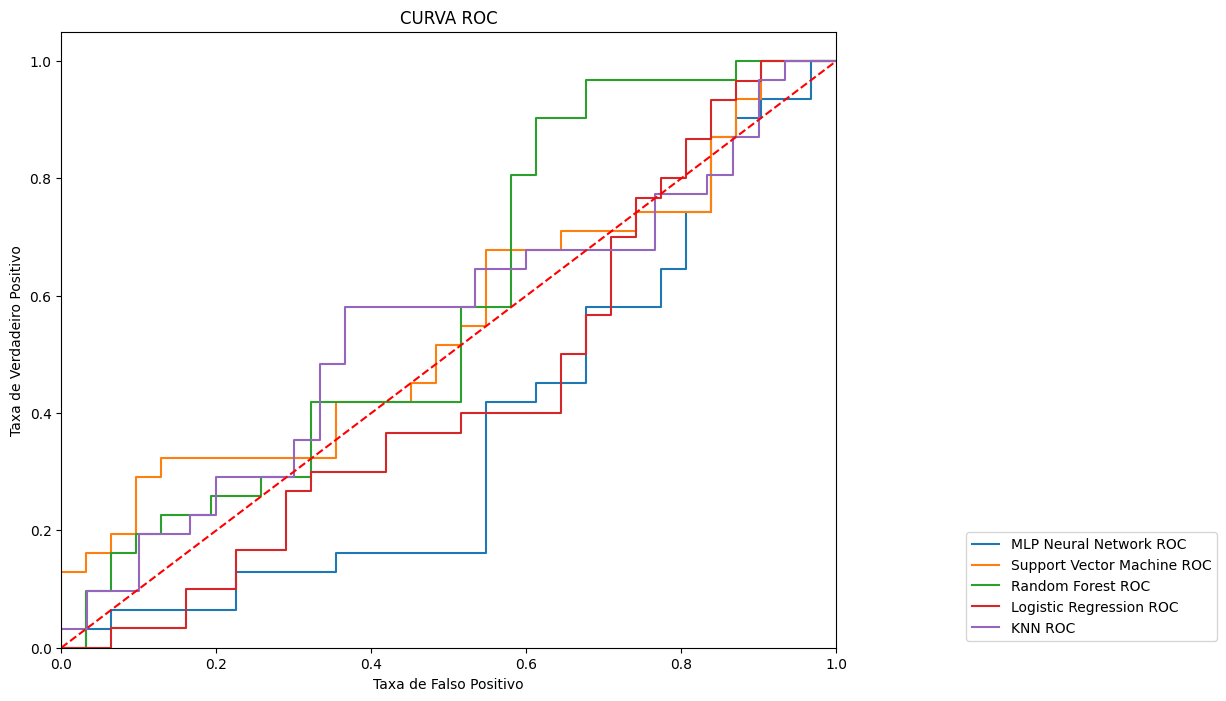

In [173]:

last_run_basic = nested_cross_validation_grid_search(lista_modelos, dfx, dfy, 5, 5, rand_state=RANDOM_STATE)


## 3.3 - Treina Ensembles (não foi publicado)

In [174]:
from copy import deepcopy

from ensemble_train_util import select_best_models_of_type_fn, select_best_models_per_fold
from ensemble_train_util import train_ensemble

In [175]:
last_run_all = deepcopy(last_run_basic)

In [176]:
#models_list = ['MLP Neural Network', 'Support Vector Machine', 'Random Forest', 'Logistic Regression', 'KNN']

for model_name in BASIC_MODEL_NAMES:
    print(f"\n\n\n **** TREINANDO ENSEMBLE PARA {model_name} ****\n")
    contracted_name = ''.join([name[0] for name in model_name.split()])
    results_ensemble = train_ensemble(select_best_models_of_type_fn(model_name), last_run_all, dfx, dfy, name_prefix=contracted_name)

    # merge results with results_with_ensemble
    last_run_all.update(results_ensemble)




 **** TREINANDO ENSEMBLE PARA MLP Neural Network ****

..........


 **** TREINANDO ENSEMBLE PARA Support Vector Machine ****

..........


 **** TREINANDO ENSEMBLE PARA Random Forest ****

..........


 **** TREINANDO ENSEMBLE PARA Logistic Regression ****

.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached 

...

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached 

...

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


...

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(





 **** TREINANDO ENSEMBLE PARA KNN ****

..........

In [177]:
results_ensemble = train_ensemble(select_best_models_per_fold, last_run_basic, dfx, dfy, name_prefix="BPF")  # BPF - best per fold

# check if keys have no intersection (no common key)
assert len(set(last_run_all.keys()) & set(results_ensemble.keys())) == 0

# merge results with results_with_ensemble
last_run_all.update(results_ensemble)

.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## 3.4 - Salva Resultados

In [178]:
from util import save_results

In [179]:
last_run_all.keys()

dict_keys(['MLP Neural Network', 'Support Vector Machine', 'Random Forest', 'Logistic Regression', 'KNN', 'MNN-hard-vote', 'MNN-soft-vote', 'SVM-hard-vote', 'SVM-soft-vote', 'RF-hard-vote', 'RF-soft-vote', 'LR-hard-vote', 'LR-soft-vote', 'K-hard-vote', 'K-soft-vote', 'BPF-hard-vote', 'BPF-soft-vote'])

In [180]:
OUTPUT_FILE_PATH = f'resultados/resultados50p_{START_DATE_STR}_{SUB_DATASET}({MODEL_NAME})_({SOCIAL_NETWORK}).npy'

save_results(OUTPUT_FILE_PATH, last_run_all, metadata)

print("Arquivo salvo:", OUTPUT_FILE_PATH)

Arquivo salvo: resultados/resultados50p_2025-03-17-16h09m_lula(mxbai-embed-large-v1)_(tiktok).npy


----

# FIM